# Implementing GeMpy into PyMC3

### Generating data

In [1]:
# Importing and data
import theano.tensor as T
import theano
import sys, os
sys.path.append("../GeMpy")

# Importing GeMpy modules
import GeMpy

# Reloading (only for development purposes)
import importlib
importlib.reload(GeMpy)

# Usuful packages
import numpy as np
import pandas as pn

import matplotlib.pyplot as plt

# This was to choose the gpu
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Default options of printin
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)

#%matplotlib inline
%matplotlib inline



# Setting the extent
geo_data = GeMpy.import_data([0,10,0,10,0,10], [50,50,50])


# =========================
# DATA GENERATION IN PYTHON
# =========================
# Layers coordinates
layer_1 = np.array([[0.5,4,7], [2,4,6.5], [4,4,7], [5,4,6]])#-np.array([5,5,4]))/8+0.5
layer_2 = np.array([[3,4,5], [6,4,4],[8,4,4], [7,4,3], [1,4,6]])
layers = np.asarray([layer_1,layer_2])

# Foliations coordinates
dip_pos_1 = np.array([7,4,7])#- np.array([5,5,4]))/8+0.5
dip_pos_2 = np.array([2.,4,4])

# Dips
dip_angle_1 = float(15)
dip_angle_2 = float(340)
dips_angles = np.asarray([dip_angle_1, dip_angle_2], dtype="float64")

# Azimuths
azimuths = np.asarray([90,90], dtype="float64")

# Polarity
polarity = np.asarray([1,1], dtype="float64")

# Setting foliations and interfaces values
GeMpy.set_interfaces(geo_data, pn.DataFrame(
    data = {"X" :np.append(layer_1[:, 0],layer_2[:,0]),
            "Y" :np.append(layer_1[:, 1],layer_2[:,1]),
            "Z" :np.append(layer_1[:, 2],layer_2[:,2]),
            "formation" : np.append(
               np.tile("Layer 1", len(layer_1)), 
               np.tile("Layer 2", len(layer_2))),
            "labels" : [r'${\bf{x}}_{\alpha \, 0}^1$',
               r'${\bf{x}}_{\alpha \, 1}^1$',
               r'${\bf{x}}_{\alpha \, 2}^1$',
               r'${\bf{x}}_{\alpha \, 3}^1$',
               r'${\bf{x}}_{\alpha \, 0}^2$',
               r'${\bf{x}}_{\alpha \, 1}^2$',
               r'${\bf{x}}_{\alpha \, 2}^2$',
               r'${\bf{x}}_{\alpha \, 3}^2$',
               r'${\bf{x}}_{\alpha \, 4}^2$'] }))

GeMpy.set_foliations(geo_data,  pn.DataFrame(
    data = {"X" :np.append(dip_pos_1[0],dip_pos_2[0]),
            "Y" :np.append(dip_pos_1[ 1],dip_pos_2[1]),
            "Z" :np.append(dip_pos_1[ 2],dip_pos_2[2]),
            "azimuth" : azimuths,
            "dip" : dips_angles,
            "polarity" : polarity,
            "formation" : ["Layer 1", "Layer 2"],
            "labels" : [r'${\bf{x}}_{\beta \,{0}}$',
              r'${\bf{x}}_{\beta \,{1}}$'] })) 



layer_3 = np.array([[2,4,3], [8,4,2], [9,4,3]])
dip_pos_3 = np.array([1,4,1])
dip_angle_3 = float(80)
azimuth_3 = 90
polarity_3 = 1



GeMpy.set_interfaces(geo_data, pn.DataFrame(
    data = {"X" :layer_3[:, 0],
            "Y" :layer_3[:, 1],
            "Z" :layer_3[:, 2],
            "formation" : np.tile("Layer 3", len(layer_3)), 
            "labels" : [  r'${\bf{x}}_{\alpha \, 0}^3$',
                           r'${\bf{x}}_{\alpha \, 1}^3$',
                           r'${\bf{x}}_{\alpha \, 2}^3$'] }), append = True)
GeMpy.get_raw_data(geo_data,"interfaces")


GeMpy.set_foliations(geo_data, pn.DataFrame(data = {
                     "X" : dip_pos_3[0],
                     "Y" : dip_pos_3[1],
                     "Z" : dip_pos_3[2],
            
                     "azimuth" : azimuth_3,
                     "dip" : dip_angle_3,
                     "polarity" : polarity_3,
                     "formation" : [ 'Layer 3'],
                     "labels" : r'${\bf{x}}_{\beta \,{2}}$'}), append = True)


GeMpy.set_data_series(geo_data, {'younger': ('Layer 1', 'Layer 2'),
                      'older': 'Layer 3'}, order_series = ['younger', 'older'])




In [2]:
# Select series to interpolate (if you do not want to interpolate all)
new_series = GeMpy.select_series(geo_data, ['younger'])
data_interp = GeMpy.set_interpolator(new_series, u_grade = 0)

In [3]:
geo_data

In [5]:
# This are the shared parameters and the compilation of the function. This will be hidden as well at some point
input_data_T = data_interp.interpolator.tg.input_parameters_list()
debugging = theano.function(input_data_T, data_interp.interpolator.tg.potential_field_at_all(), on_unused_input='ignore',
                            allow_input_downcast=True, profile=True)

In [6]:
# This prepares the user data to the theano function
input_data_P = data_interp.interpolator.data_prep() 

# Solution of theano
sol = debugging(input_data_P[0], input_data_P[1], input_data_P[2], input_data_P[3],input_data_P[4], input_data_P[5])

In [7]:
sol.shape

(125014,)

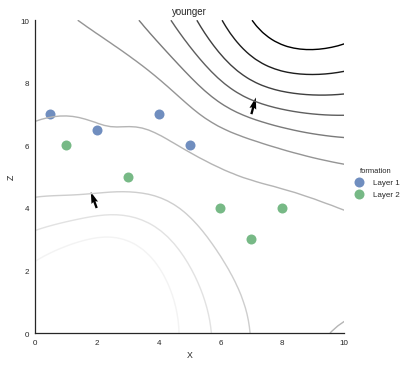

In [8]:
GeMpy.plot_potential_field(new_series, sol[:-14].reshape(50,50,50),13, plot_data = True)

In [9]:
# If you change the values here. Here changes the plot as well
geo_data.foliations.set_value(0, 'dip', 40)

,G_x,G_y,G_z,X,Y,Z,azimuth,dip,formation,labels,order_series,polarity,series
0,0.258819,1.584810e-17,0.965926,7.0,4.0,7.0,90.0,40.0,Layer 1,"${\bf{x}}_{\beta \,{0}}$",1,1.0,younger
1,-0.342020,-2.094269e-17,0.939693,2.0,4.0,4.0,90.0,340.0,Layer 2,"${\bf{x}}_{\beta \,{1}}$",1,1.0,younger
0,0.984808,6.030208e-17,0.173648,1.0,4.0,1.0,90.0,40.0,Layer 3,"${\bf{x}}_{\beta \,{2}}$",2,1.0,older


In [10]:
# You need to set the interpolator again
new_series = GeMpy.select_series(geo_data, ['younger'])
data_interp = GeMpy.set_interpolator(new_series, u_grade = 0, verbose= ['cov_function'])


In [11]:
# If you change it here is not necesary. Maybe some function in GeMpy with an attribute to choose would be good
data_interp.interpolator._data_scaled.foliations.set_value(0, 'dip', 40)
# In any case, data prep has to be called to convert the data to pure arrays. This function should be hidden I guess
input_data_P = data_interp.interpolator.data_prep()

In [12]:
sol = debugging(input_data_P[0], input_data_P[1], input_data_P[2], input_data_P[3],input_data_P[4], input_data_P[5])

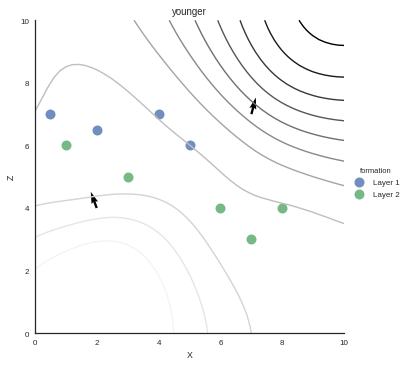

In [13]:
GeMpy.plot_potential_field(new_series, sol[:-14].reshape(50,50,50),13, plot_data = True)

## PyMC3

In [21]:
data_interp = GeMpy.set_interpolator(geo_data, u_grade = 0)

# This are the shared parameters and the compilation of the function. This will be hidden as well at some point
input_data_T = data_interp.interpolator.tg.input_parameters_list()
# This prepares the user data to the theano function
input_data_P = data_interp.interpolator.data_prep() 

In [22]:
# We create the op. Because is an op we cannot call it with python variables anymore. Thats why we have to make them shared
# Before
op2 = theano.OpFromGraph(input_data_T, [data_interp.interpolator.tg.whole_block_model()], on_unused_input='ignore')

In [24]:
import pymc3 as pm
theano.config.compute_test_value = 'ignore'
model = pm.Model()
with model:
    # Stochastic value
    foliation = pm.Normal('foliation', 40, sd=30)
    
    # We convert a python variable to theano.shared
    dips = theano.shared(input_data_P[1])
    
    # We add the stochastic value to the correspondant array
    dips = T.set_subtensor(dips[0], foliation)

    geo_model = pm.Deterministic('GeMpy', op2(theano.shared(input_data_P[0]), dips, 
                                     theano.shared(input_data_P[2]), theano.shared(input_data_P[3]),
                                     theano.shared(input_data_P[4]), theano.shared(input_data_P[5])))

    trace = pm.sample(6)

Assigned NUTS to foliation
 [-----------------100%-----------------] 6 of 6 complete in 2.9 sec

In [27]:
trace.varnames, trace.get_values("GeMpy")

(['foliation', 'GeMpy'], array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]))

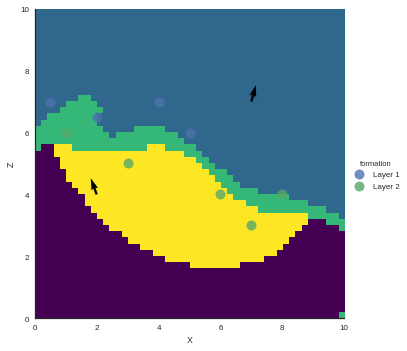

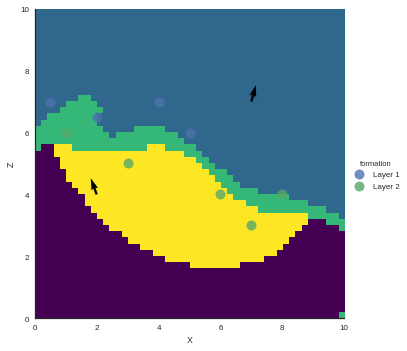

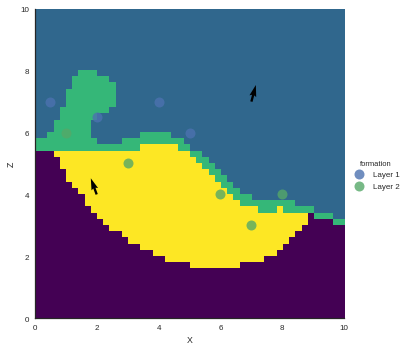

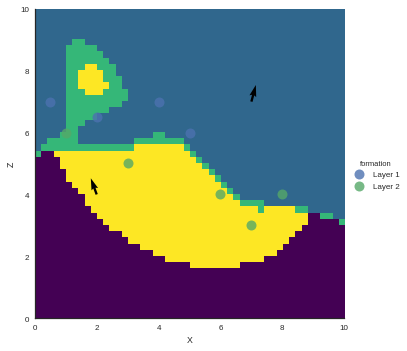

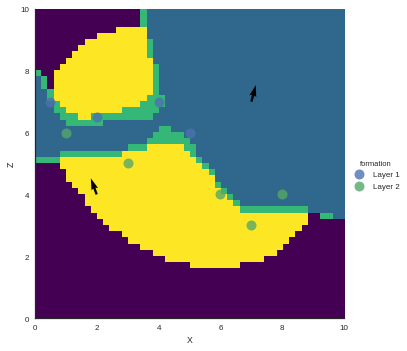

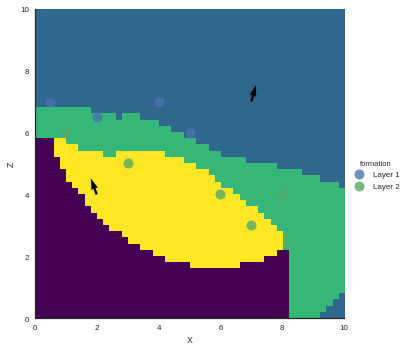

In [28]:
for i in trace.get_values('GeMpy'):
    GeMpy.plot_section(new_series, 13, block = i, plot_data = True)

## Cholesky  (Under development)

In [ ]:
# Cholesky solution
L = np.linalg.cholesky(C)
U = sc.linalg.cholesky(C)
Y = sc.linalg.solve_triangular(L,b, lower=True)
x = sc.linalg.solve_triangular(L.conj().T, Y)

In [ ]:
import scipy as sc
Y = sc.linalg.solve_triangular?

In [ ]:
debugging.profile.summary()

In [ ]:
data_interp.interpolator.tg.dips_position_all.set_value(input_data_P[0])
data_interp.interpolator.tg.dip_angles_all.set_value(input_data_P[1])
data_interp.interpolator.tg.azimuth_all.set_value(input_data_P[2])
data_interp.interpolator.tg.polarity_all.set_value(input_data_P[3])
data_interp.interpolator.tg.ref_layer_points_all.set_value(input_data_P[4])
data_interp.interpolator.tg.rest_layer_points_all.set_value(input_data_P[5])